In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import json
import networkx as nx
from project_utils import *
from pandas.io.json import json_normalize
from functools import reduce
from scipy import sparse

%reload_ext lab_black

In [ ]:
credits_df = pd.read_csv("./data/tmdb_5000_credits.csv", sep=",", quotechar='"')
credits_df.head()

In [ ]:
movies_df = pd.read_csv("./data/tmdb_5000_movies.csv", sep=",", quotechar='"').rename(
    {"id": "movie_id"}, axis=1
)
movies_df.head()

In [ ]:
credits_df_cp = credits_df.copy()
movies_df_cp = movies_df.copy()

## Clean movies_df_cp

In [ ]:
# movies with empty genre field
len(movies_df_cp[movies_df_cp.astype(str)["genres"] == "[]"])

In [ ]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["production_companies"] == "[]"])

In [ ]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["production_countries"] == "[]"])

In [ ]:
# movies with empty production_companies field
len(movies_df_cp[movies_df_cp.astype(str)["spoken_languages"] == "[]"])

## Process movies df

In [ ]:
pr_movies_df = movies_df_cp
len(pr_movies_df)

In [ ]:
pr_movies_df.head()

In [ ]:
# Transform json to list of dictionaries within cols
movies_df_json_cols = [
    "genres",
    "production_companies",
    "keywords",
    "production_countries",
    "spoken_languages",
]
cols_to_drop = ["homepage", "overview", "tagline", "original_title"]
key = "name"
movie_id_col = "movie_id"

pr_movies_df = col_json_to_dict(pr_movies_df, movies_df_json_cols)
for col in movies_df_json_cols:
    pr_movies_df = col_dict_to_set(pr_movies_df, col, key)
pr_movies_df = pr_movies_df.drop(columns=cols_to_drop)
pr_movies_df.head()

## Process credits df

In [ ]:
pr_credits_df = credits_df_cp
credits_df_json_cols = ["cast", "crew"]
key = "name"
pr_credits_df = col_json_to_dict(pr_credits_df, credits_df_json_cols)
pr_credits_df = pr_credits_df.assign(actors=pr_credits_df[credits_df_json_cols[0]])
for col in credits_df_json_cols:
    if col != "crew":
        pr_credits_df = col_dict_to_set(pr_credits_df, col, key)
crew_col = "crew"
job_field = "job"
values = ["Director"]
# Filter dictionaries with Director as job
pr_credits_df = col_filter_dict_with_vals(
    pr_credits_df, crew_col, job_field, values
).rename({crew_col: values[0]})
pr_credits_df = col_dict_to_set(pr_credits_df, crew_col, key)
# Get actors col
# Only select main actors to reduce the size of the dataset
actors_col = "actors"
order_field = "order"
# Select the number of important actors
values = [0, 1]
pr_credits_df = col_filter_dict_with_vals(
    pr_credits_df, actors_col, order_field, values
).rename({crew_col: values[0]})

get_value = lambda dict_: dict_.get(key)

pr_credits_df = pr_credits_df.explode(actors_col)
pr_credits_df = pr_credits_df[pr_credits_df[actors_col].notna()]
actors_series = pr_credits_df[actors_col]
pr_credits_df = pr_credits_df.assign(
    **{actors_col: pr_credits_df[actors_col].apply(get_value)}
)
# Remove actor from cast
actor_cast_col = "actor_cast"
pr_credits_df = pr_credits_df.reset_index(drop=True)
remove_from_cast = lambda row: row[credits_df_json_cols[0]] - set({row[actors_col]})
pr_credits_df = pr_credits_df.assign(
    **{credits_df_json_cols[0]: pr_credits_df.apply(remove_from_cast, axis=1)}
).drop(columns="title")
pr_credits_df.head()

In [ ]:
actor_cols = ["name", "gender", "order"]
actors_df = json_normalize(actors_series)[actor_cols]
actors_df = (
    actors_df.rename(columns={actor_cols[0]: actors_col})
    .groupby(actors_col)
    .aggregate({actor_cols[1]: max, actor_cols[2]: list})
    .reset_index()
    .reset_index()
    .rename(columns={"index": "actor_id"})
)
actors_df

In [ ]:
actors_credits_df = pr_credits_df.merge(
    actors_df, right_on=actors_col, left_on=actors_col, how="inner"
)
actors_credits_df.head(20)

In [ ]:
movie_id_col = "movie_id"
new_movie_id_col = "new_movie_id"
actors_movies_credits_df = actors_credits_df.merge(
    pr_movies_df, right_on=movie_id_col, left_on=movie_id_col, how="inner"
)
# Set new movie ids
unique_movies_df = (
    pr_movies_df[movie_id_col]
    .to_frame()
    .drop_duplicates()
    .reset_index()
    .rename(columns={"index": new_movie_id_col})
)
actors_movies_credits_df = (
    actors_movies_credits_df.merge(
        unique_movies_df, right_on=movie_id_col, left_on=movie_id_col, how="inner"
    )
    .drop(columns=movie_id_col)
    .rename(columns={new_movie_id_col: movie_id_col})
)

actors_movies_credits_df.head()

In [ ]:
aux_movies_df = unique_movies_df.merge(
    pr_movies_df[["movie_id", "title"]].drop_duplicates(),
    right_on="movie_id",
    left_on="movie_id",
)
aux_movies_df.head()

In [ ]:
actors_movies_credits_df.columns

In [ ]:
len(actors_movies_credits_df)

In [ ]:
get_union = lambda s: reduce(set.union, s)
actor_id_col = "actor_id"
actors_agg_df = (
    actors_movies_credits_df.groupby(actors_col)
    .aggregate(
        {
            "movie_id": set,
            "cast": get_union,
            "crew": get_union,
            "actor_id": max,
            "gender": max,
            "budget": "mean",
            "genres": get_union,
            "keywords": get_union,
            "original_language": set,
            "popularity": "mean",
            "production_companies": get_union,
            "production_countries": get_union,
            "release_date": list,
            "revenue": "mean",
            "runtime": sum,
            "spoken_languages": get_union,
            "status": list,
            "title": set,
            "vote_average": "mean",
            "vote_count": "mean",
        }
    )
    .set_index(actor_id_col)
)
actors_agg_df.head()

## Build graph

In [ ]:
nodes_df = actors_agg_df[["cast", "crew", "production_companies", "genres", "movie_id"]]
nodes_df.head()

In [ ]:
dict_actor_id = dict(zip(actors_df[actors_col], actors_df[actor_id_col]))
dict_id_actor = dict(zip(actors_df[actor_id_col], actors_df[actors_col]))

## Get cast intersecctions length mat

## Get cast intersections

In [ ]:
col = "cast"
cast_col = nodes_df[col]
cast_adj_raw = get_intersections_length_adj_mat(cast_col)
cast_adj_diag = np.diag(np.diag(cast_adj_raw))
cast_adj = cast_adj_raw - cast_adj_diag

In [ ]:
plt.spy(cast_adj)

In [ ]:
np.save("cast_adj", cast_adj)

## Load cast adjacency matrix

In [ ]:
cast_adj = np.load("cast_adj.npy")

In [ ]:
cast_adj.shape

In [ ]:
node_degree = cast_adj.sum(axis=0)

In [ ]:
most_connected_actors_id = np.argsort(-node_degree)[:20]
most_connected_actors = [dict_id_actor.get(id_) for id_ in most_connected_actors_id]
actors_df[actors_df[actor_id_col].isin(most_connected_actors_id)]
print(most_connected_actors)

## Get cast unions length mat

In [ ]:
col = "cast"
cast_col = nodes_df[col]
cast_adj_union_raw = get_unions_length_adj_mat(cast_col)
cast_adj_union_diag = np.diag(np.diag(cast_adj_union_raw))
cast_adj_union = cast_adj_union_raw - cast_adj_union_diag

In [ ]:
plt.imshow(cast_adj_union, cmap="hot", interpolation="none")

In [ ]:
np.save("cast_adj_union", cast_adj_union)

## Get movies intersections length mat

In [ ]:
col = "movie_id"
movie_col = nodes_df[col]
movie_adj_raw = get_intersections_length_adj_mat(movie_col)
movie_adj_diag = np.diag(np.diag(movie_adj_raw))
movie_adj = movie_adj_raw - movie_adj_diag

In [ ]:
plt.spy(movie_adj)

In [ ]:
np.save("movie_adj", movie_adj)

## Get movies union length mat

In [ ]:
col = "movie_id"
movie_col = nodes_df[col]
movie_adj_union_raw = get_unions_length_adj_mat(movie_col)
movie_adj_union_diag = np.diag(np.diag(movie_adj_union_raw))
movie_adj_union = movie_adj_union_raw - movie_adj_union_diag

In [ ]:
plt.imshow(movie_adj_union, cmap="hot", interpolation="none")

In [ ]:
np.save("movie_adj_union", movie_adj_union)

## Get directors intersections lenght mat

In [ ]:
col = "crew"
crew_col = nodes_df[col]
crew_adj_raw = get_intersections_length_adj_mat(crew_col)
crew_adj_diag = np.diag(np.diag(crew_adj_raw))
crew_adj = crew_adj_raw - crew_adj_diag

In [ ]:
plt.spy(crew_adj)

In [ ]:
np.save("crew_adj", crew_adj)

## Get directors union length mat

In [ ]:
col = "crew"
crew_col = nodes_df[col]
crew_adj_union_raw = get_unions_length_adj_mat(crew_col)
crew_adj_union_diag = np.diag(np.diag(crew_adj_union_raw))
crew_adj_union = crew_adj_union_raw - crew_adj_union_diag

In [ ]:
plt.imshow(crew_adj_union, cmap="hot", interpolation="none")

In [ ]:
np.save("crew_adj_union", crew_adj_union)

## Get production companies intersections length mat

In [ ]:
col = "production_companies"
prod_comp_col = nodes_df[col]
prod_comp_adj_raw = get_intersections_length_adj_mat(prod_comp_col)
prod_comp_adj_diag = np.diag(np.diag(prod_comp_adj_raw))
prod_comp_adj = prod_comp_adj_raw - prod_comp_adj_diag

In [ ]:
plt.spy(prod_comp_adj)

In [ ]:
np.save("prod_comp_adj", prod_comp_adj)

## Get production companies unions length mat

In [ ]:
col = "production_companies"
prod_comp_col = nodes_df[col]
prod_comp_adj_union_raw = get_unions_length_adj_mat(prod_comp_col)
prod_comp_adj_union_diag = np.diag(np.diag(prod_comp_adj_union_raw))
prod_comp_adj_union = prod_comp_adj_union_raw - prod_comp_adj_union_diag

In [ ]:
plt.imshow(prod_comp_adj_union, cmap="hot", interpolation="none")

In [ ]:
np.save("prod_comp_adj_union", prod_comp_adj_union)

## Get genres intersections length mat

In [ ]:
col = "genres"
genres_col = nodes_df[col]
genres_adj_raw = get_intersections_length_adj_mat(genres_col)
genres_adj_diag = np.diag(np.diag(genres_adj_raw))
genres_adj = genres_adj_raw - genres_adj_diag

In [ ]:
plt.spy(genres_adj)

In [ ]:
np.save("genres_adj", genres_adj)

## Get genres unions length mat

In [ ]:
col = "genres"
genres_col = nodes_df[col]
genres_adj_union_raw = get_unions_length_adj_mat(genres_col)
genres_adj_union_diag = np.diag(np.diag(genres_adj_union_raw))
genres_adj_union = genres_adj_union_raw - genres_adj_union_diag

In [59]:
plt.imshow(genres_adj_union, cmap="hot", interpolation="none")

In [60]:
np.save("genres_adj_union", genres_adj_union)

## Aggregated adjacency matrix

In [61]:
agg_adj = np.divide(
    (
        0.3 * cast_adj
        + 0.3 * movie_adj
        + 0.2 * crew_adj
        + 0.1 * genres_adj
        + 0.1 * prod_comp_adj
    ),
    (
        0.3 * cast_adj_union
        + 0.3 * movie_adj_union
        + 0.2 * crew_adj_union
        + 0.1 * genres_adj_union
        + 0.1 * prod_comp_adj_union
    ),
)
agg_adj = np.where(np.isnan(agg_adj), 0, agg_adj)
np.sum(agg_adj)

C:\Users\AndresMontero\.conda\envs\ntds_2019\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


77236.65386911613

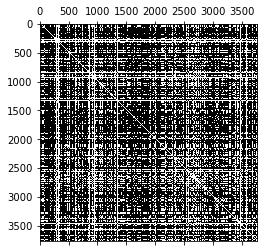

In [62]:
plt.spy(agg_adj)

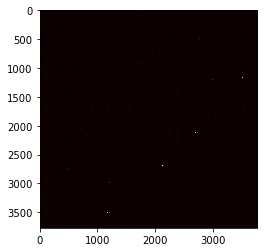

In [63]:
plt.imshow(agg_adj, cmap="hot", interpolation="none")

In [64]:
np.min(agg_adj)

0.0

In [65]:
np.max(agg_adj)

0.9850374064837905

In [66]:
np.save("agg_adj", agg_adj)

In [ ]:
np.load("agg_adj.npy")

## Sparsify graph

In [67]:
agg_adj = np.load("agg_adj.npy")

In [68]:
def sparsify_adj(adj, epsilon):
    return np.where(adj <= epsilon, 0, adj)

In [69]:
percentile = 70
eps = np.percentile(agg_adj, 70)
print(eps)

0.007038783699837348


In [70]:
sparse_agg_adj = sparsify_adj(agg_adj, eps)

## Tests

### Test consistency of data

In [75]:
dict_actor_id.get("Sam Worthington")

3169

In [76]:
actors_df[actors_df["actors"] == "Adriana Barraza"]

,actor_id,actors,gender,order
45,45,Adriana Barraza,1,[0]


In [77]:
dict_actor_id.get("Andreas Berg")

In [78]:
actors_df[actors_df["actor_id"] == 1000]

,actor_id,actors,gender,order
1000,1000,Elden Henson,2,"[1, 1]"


In [79]:
nodes_df.loc[0, "cast"]

{'Anthony Geary',
 'Billy Barty',
 'David Bowe',
 'Emo Philips',
 'Fran Drescher',
 'Kevin McCarthy',
 'Michael Richards',
 'Trinidad Silva',
 'Victoria Jackson'}

In [80]:
# Test number of actors
len(np.unique(actors_agg_df.index.values))

3770

In [81]:
actors_agg_df

,movie_id,cast,crew,gender,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,title,vote_average,vote_count
actor_id,,,,,,,,,,,,,,,,,,,
0,{3619},"{David Bowe, Trinidad Silva, Anthony Geary, Mi...",{Jay Levey},0,5.000000e+06,{Comedy},"{indiana jones spoof scene, satire, tv star, g...",{en},4.070044,"{Cinecorp, Orion Pictures}",{United States of America},[1989-07-21],0.000000e+00,97.0,{English},[Released],{UHF},6.700000,89.000000
1,{1233},"{Sullivan Walker, Terrence Howard, Joseph Pier...",{Jim Sheridan},2,4.000000e+07,{Drama},"{career, musical, attempted murder, drug, rapp...",{en},12.885985,"{Paramount Pictures, MTV Films, Cent Productio...",{United States of America},[2005-11-09],4.644253e+07,117.0,{English},[Released],{Get Rich or Die Tryin'},6.300000,186.000000
2,{4034},"{Ron Roggé, Vanessa Evigan, Piper Mackenzie Ha...",{John Murlowski},2,0.000000e+00,"{Comedy, Family}",{},{en},0.630226,{},{United States of America},[2010-12-01],0.000000e+00,89.0,{English},[Released],{Christmas Mail},5.000000,15.000000
3,{1789},"{Alejandro Rae, Shaun Sipos, Ali Larter, Micha...",{David R. Ellis},1,2.600000e+07,"{Mystery, Horror}","{hospital, premonition, ambulance}",{en},37.355826,"{New Line Cinema, Zide-Perry Productions}",{United States of America},[2003-01-31],9.042640e+07,90.0,{English},[Released],{Final Destination 2},5.900000,1023.000000
4,{4203},"{Kevin Pollak, James Denton, Jamie Grace, Shaw...",{Brad J. Silverman},1,0.000000e+00,"{Drama, Music}",{christian},{en},2.160586,"{Birchwood Pictures, Coram Deo Studios}",{United States of America},[2013-10-04],0.000000e+00,102.0,{English},[Released],{Grace Unplugged},6.000000,24.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3765,{3979},"{Kellie Geradi, Kelli Chaves, James Leibow, Ca...","{Morgan Spurlock, Alex Gibney, Eugene Jarecki,...",0,3.000000e+06,{Documentary},"{experiment, cheating, corruption, limousine, ...",{en},1.781462,"{Chad Troutwine Films, Loki Films, Green Film ...",{United States of America},[2010-10-01],1.037350e+05,93.0,{English},[Released],{Freakonomics},6.600000,36.000000
3766,"{3847, 3339, 1068, 913, 723, 4373}","{Molly Sims, Traci Law, Maurice Compte, Gregor...","{M. Night Shyamalan, Peyton Reed, Garth Jennin...",1,3.183333e+07,"{Drama, Romance, Comedy, Science Fiction, Fami...","{spaceship, dolphin, intergalactic travel, bas...",{en},28.167807,"{Warner Bros., Watermark, UTV Motion Pictures,...","{India, United States of America, France}","[2005-01-15, 2008-06-11, 2008-12-09, 2009-07-1...",9.245162e+07,605.0,"{Français, svenska, English, Eesti, 한국어/조선말}","[Released, Released, Released, Released, Relea...","{The Happening, (500) Days of Summer, All the ...",6.283333,1173.333333
3767,{3691},"{Don McKellar, Kim Ly, Ariadna Gil, Douglas Sm...",{Analeine Cal y Mayor},1,4.700000e+06,"{Comedy, Drama}","{parenting, boy, woman director, self acceptan...",{en},0.217538,"{Mecanismo Films, Redrum, Rhombus Media}","{Mexico, Canada}",[2013-09-13],0.000000e+00,92.0,{English},[Released],{Treading Water},5.600000,6.000000


In [82]:
test_movie_id = actors_agg_df.loc[dict_actor_id.get("Sam Worthington")]["movie_id"]
test_movie_id

{0, 43, 132, 206, 1146, 1448}

In [83]:
test_movies_df = unique_movies_df[
    unique_movies_df[new_movie_id_col].isin(test_movie_id)
]
test_movies_df = test_movies_df.merge(
    pr_movies_df, right_on=movie_id_col, left_on=movie_id_col
)
test_movies_df[[movie_id_col, new_movie_id_col, "title"]]

,movie_id,new_movie_id,title
0,19995,0,Avatar
1,534,43,Terminator Salvation
2,57165,132,Wrath of the Titans
3,18823,206,Clash of the Titans
4,49527,1146,Man on a Ledge
5,144336,1448,Sabotage


In [84]:
"Sam Worthington" in pr_credits_df.loc[0, "cast"]

False

In [85]:
pr_credits_df.loc[0]

movie_id                                                19995
cast        {Zoe Saldana, Jamie Harrison, Mike Bodnar, Tay...
crew                                          {James Cameron}
actors                                        Sam Worthington
Name: 0, dtype: object